

# XDAWN Decoding From EEG data

ERP decoding with Xdawn :footcite:`RivetEtAl2009,RivetEtAl2011`. For each event
type, a set of spatial Xdawn filters are trained and applied on the signal.
Channels are concatenated and rescaled to create features vectors that will be
fed into a logistic regression.


In [1]:
# Authors: Alexandre Barachant <alexandre.barachant@gmail.com>
#
# License: BSD-3-Clause

In [41]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import (LogisticRegression, ARDRegression,
    BayesianRidge,
    ElasticNet,
    ElasticNetCV,
    Hinge,
    Huber,
    HuberRegressor,
    Lars,
    LarsCV,
    Lasso,
    LassoCV,
    LassoLars,
    LassoLarsCV,
    LassoLarsIC,
    LinearRegression,
    Log,
    LogisticRegression,
    LogisticRegressionCV,
    ModifiedHuber,
    MultiTaskElasticNet,
    MultiTaskElasticNetCV,
    MultiTaskLasso,
    MultiTaskLassoCV,
    OrthogonalMatchingPursuit,
    OrthogonalMatchingPursuitCV,
    PassiveAggressiveClassifier,
    PassiveAggressiveRegressor,
    Perceptron,
    QuantileRegressor,
    Ridge,
    RidgeCV,
    RidgeClassifier,
    RidgeClassifierCV,
    SGDClassifier,
    SGDRegressor,
    SGDOneClassSVM,
    SquaredLoss,
    TheilSenRegressor,
    enet_path,
    lars_path,
    lars_path_gram,
    lasso_path,
    orthogonal_mp,
    orthogonal_mp_gram,
    ridge_regression,
    RANSACRegressor,
    PoissonRegressor,
    GammaRegressor)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from mne import io, pick_types, read_events, Epochs, EvokedArray, create_info, events_from_annotations
from mne.datasets import sample
from mne.preprocessing import Xdawn
from mne.decoding import Vectorizer
from share import datasets_basic_infos
from data_loaders import load_data_labels_based_on_dataset
print(__doc__)

data_path = sample.data_path()

Automatically created module for IPython interactive environment


Set parameters and read data



In [44]:
# This one needs the data to be load in epochs, not in dimensions
subject_id = 15
dataset_name = 'aguilera'


dataset_foldername = dataset_name + '_dataset'
computer_root_path = "/Users/almacuevas/work_projects/voting_system_platform/Datasets/" # MAC
#computer_root_path = "/Users/rosit/Documents/MCC/voting_system_platform/Datasets/"  # OMEN

data_path = computer_root_path + dataset_foldername

dataset_info = datasets_basic_infos[dataset_name]

epochs, y = load_data_labels_based_on_dataset(dataset_name, subject_id, dataset_info, data_path, array_format=False)

Extracting EDF parameters from /Users/almacuevas/work_projects/voting_system_platform/Datasets/aguilera_dataset/S15.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 246999  =      0.000 ...   493.998 secs...
Used Annotations descriptions: ['OVTK_StimulationId_Label_01', 'OVTK_StimulationId_Label_02', 'OVTK_StimulationId_Label_03', 'OVTK_StimulationId_Label_04', 'OVTK_StimulationId_Label_05']
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 120 events and 701 original time points ...
0 bad epochs dropped


/Users/almacuevas/work_projects/voting_system_platform/Code/data_loaders.py:15: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = io.read_raw_edf(data_path, preload=True, verbose=None, exclude=['Channel 21', 'Channel 22', 'Gyro 1', 'Gyro 2', 'Gyro 3'])


Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance 

/Users/almacuevas/work_projects/voting_system_platform/env_voting_system_platform/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info


/Users/almacuevas/work_projects/voting_system_platform/env_voting_system_platform/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info


/Users/almacuevas/work_projects/voting_system_platform/env_voting_system_platform/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info


/Users/almacuevas/work_projects/voting_system_platform/env_voting_system_platform/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info


/Users/almacuevas/work_projects/voting_system_platform/env_voting_system_platform/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'


/Users/almacuevas/work_projects/voting_system_platform/env_voting_system_platform/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'


/Users/almacuevas/work_projects/voting_system_platform/env_voting_system_platform/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info


/Users/almacuevas/work_projects/voting_system_platform/env_voting_system_platform/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22


/Users/almacuevas/work_projects/voting_system_platform/env_voting_system_platform/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 22 from info
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
              precision    recall  f1-score   support

     Avanzar       0.50      0.60      0.55        30
  Retroceder       0.48      0.40      0.44        30
     Derecha       0.59      0.57      0.58        30
   Izquierda       0.47      0.47      0.47        30

    accuracy                           0.51       120
   macro avg       0.51      0.51      0.51       120
weighted avg       0.51      0.51      0.51       120



/Users/almacuevas/work_projects/voting_system_platform/env_voting_system_platform/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[Text(15.672222222222276, 0.5, 'True label'),
 Text(0.5, -26.294164779863692, 'Predicted label')]

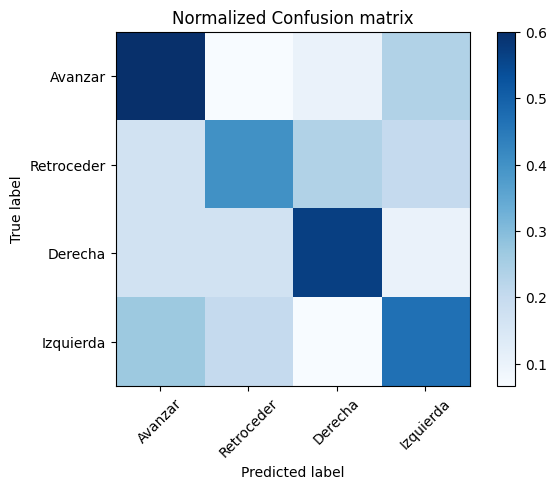

In [45]:
n_filter = 5
# Create classification pipeline
clf = make_pipeline(
    Xdawn(n_components=n_filter),
    Vectorizer(),
    MinMaxScaler(),
    LogisticRegression(penalty="l2", solver="lbfgs", multi_class="auto"),
)

# Get the labels
labels = epochs.events[:, -1]

# Cross validator
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Do cross-validation
preds = np.empty(len(labels))
for train, test in cv.split(epochs, labels):
    clf.fit(epochs[train], labels[train])
    preds[test] = clf.predict(epochs[test])

# To see the array of predictions
# array = clf.predict_proba(epochs[1])

# Classification report
target_names = ["Avanzar", "Retroceder", "Derecha", "Izquierda"]
report = classification_report(labels, preds, target_names=target_names)
print(report)

# Normalized confusion matrix
cm = confusion_matrix(labels, preds)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
fig, ax = plt.subplots(1)
im = ax.imshow(cm_normalized, interpolation="nearest", cmap=plt.cm.Blues)
ax.set(title="Normalized Confusion matrix")
fig.colorbar(im)
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
fig.tight_layout()
ax.set(ylabel="True label", xlabel="Predicted label")

The ``patterns_`` attribute of a fitted Xdawn instance (here from the last
cross-validation fold) can be used for visualization.



RuntimeError: No digitization points found.

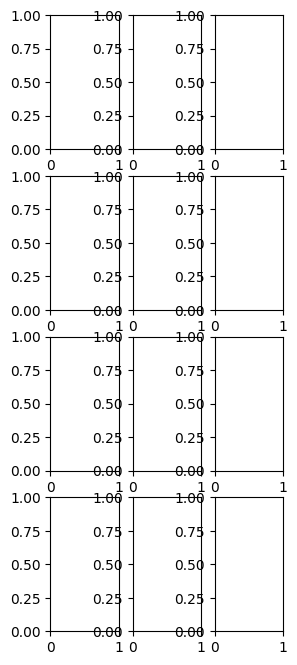

In [34]:
fig, axes = plt.subplots(
    nrows=len(event_id), ncols=n_filter, figsize=(n_filter, len(event_id) * 2)
)
fitted_xdawn = clf.steps[0][1]
info = create_info(epochs.ch_names, 1, epochs.get_channel_types())
info.set_montage(epochs.get_montage())
for ii, cur_class in enumerate(sorted(event_id)):
    cur_patterns = fitted_xdawn.patterns_[cur_class]
    pattern_evoked = EvokedArray(cur_patterns[:n_filter].T, info, tmin=0)
    pattern_evoked.plot_topomap(
        times=np.arange(n_filter),
        time_format="Component %d" if ii == 0 else "",
        colorbar=False,
        show_names=False,
        axes=axes[ii],
        show=False,
    )
    axes[ii, 0].set(ylabel=cur_class)
fig.tight_layout(h_pad=1.0, w_pad=1.0, pad=0.1)

## References
.. footbibliography::

